1. Поискать, что делать с bool значениями, если надо, перевести во что-то другое.
> ВСЕ ОК.
2. Кластеризовать ходы.
> Мне начинает казаться, что метод k-средних не очень подходит в этой ситуации, потому что кластеры не могут быть сгруппированными облаками точек в скольки-то-мерном пространстве.

In [1]:
import pandas as pd
import math
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/shogi/db40_2_move.csv', delimiter=',')

In [4]:
data

,id_kif,numb,rec_mov,rec_cp,real_cp
0,6,0,False,-57,57
1,6,1,False,106,-49
2,6,2,False,-52,-54
3,6,3,False,234,-182
4,6,4,False,-113,-121
...,...,...,...,...,...
3410087,56480,58,False,8889,-8889
3410088,56480,59,True,0,0
3410089,56480,60,False,0,0
3410090,56480,61,False,8889,-8889


Для наглядности графика логарифмируем номер хода.

In [5]:
data['numb_log'] = pd.Series(list(map(lambda x:math.ceil(math.log(x+1)),data['numb'])), index = data.index)

In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

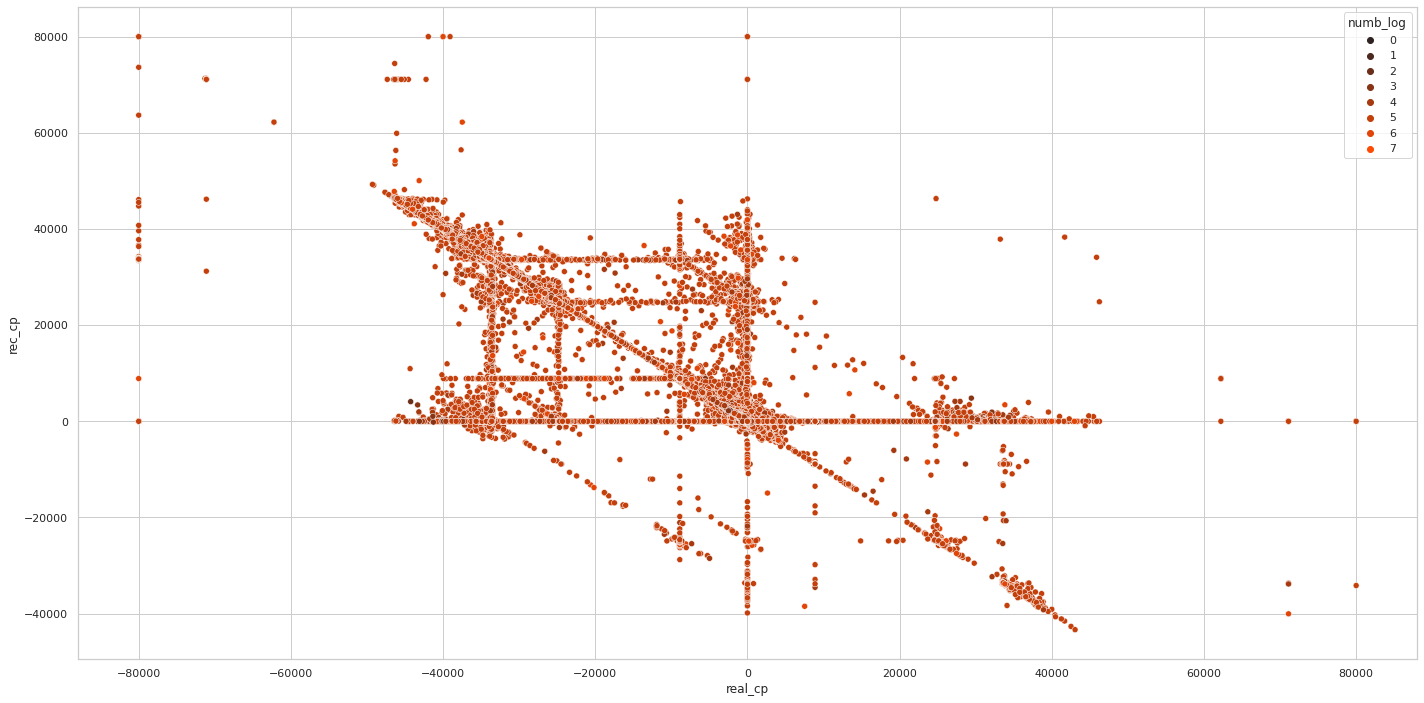

In [7]:
plt.figure(figsize=(24, 12))
sns.set(style="whitegrid")
sns.scatterplot(data=data, x="real_cp", y="rec_cp", hue="numb_log", palette=sns.dark_palette("xkcd:blood orange", n_colors=8))

In [ ]:
# f_data = data.loc[data.rec_mov == False]
# t_data = data.loc[data.rec_mov == True]

# plt.figure(figsize=(24, 16))
# with sns.axes_style("whitegrid"):
#     ax = sns.scatterplot(data=f_data, x="real_cp", y="rec_cp", label="false", hue="numb", palette="Blues")
#     ax = sns.scatterplot(data=t_data, x="real_cp", y="rec_cp", label='true', hue="numb", palette="Greens")
#     ax.set_title("Что по кластерам")

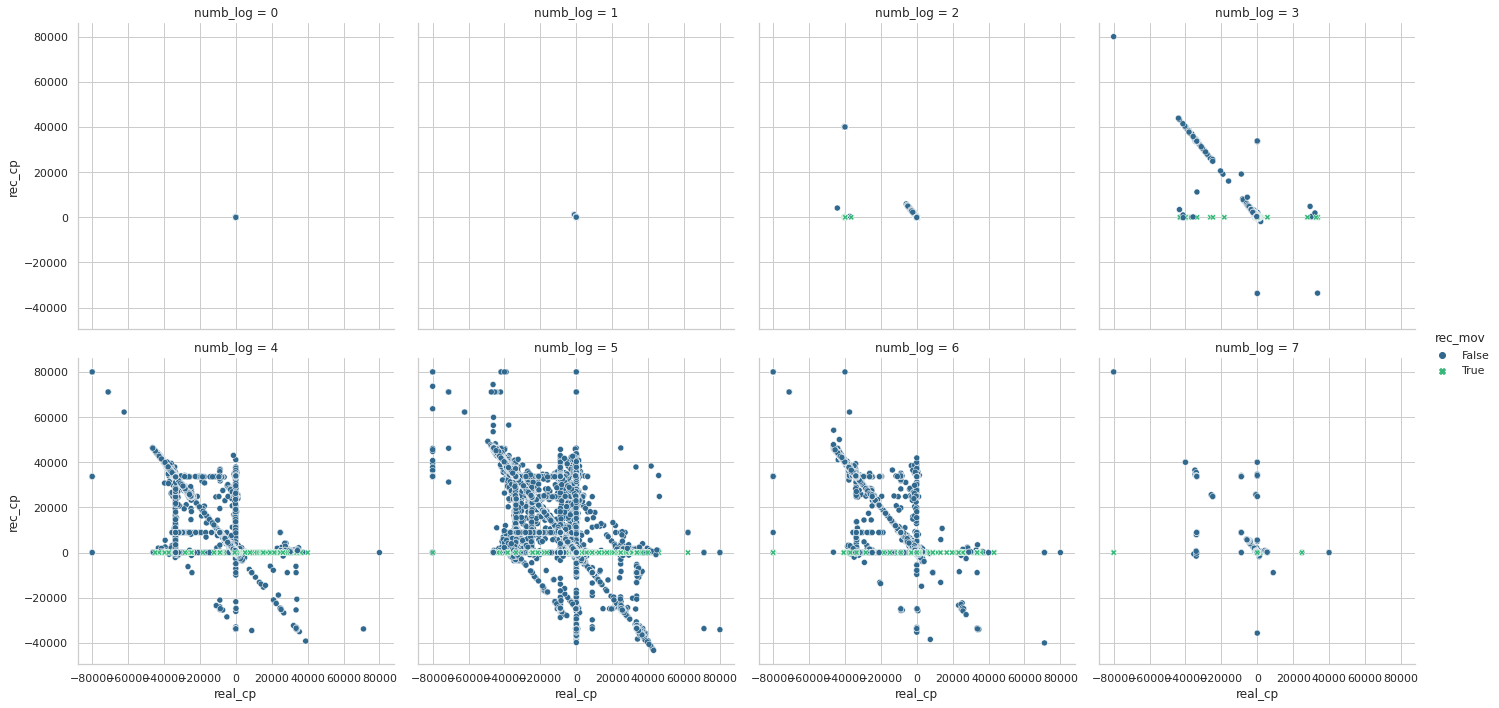

In [8]:
sns.relplot(
    data=data, x="real_cp", y="rec_cp",
    col="numb_log", col_wrap=4, hue="rec_mov", style="rec_mov",
    kind="scatter", palette='viridis'
)

In [ ]:
max(data.iloc[:,4])

124444

In [ ]:
min(data.iloc[:,4])

-103703

Мы узнали значение самой большой суммы значений cp в течении игры.

In [ ]:
data.loc[data.real_cp.nsmallest(1).index[0]]

id_kif       32932
numb           114
rec_mov      False
rec_cp      103703
real_cp    -103703
Name: 1868390, dtype: object

Мы узнали для игры с наименьшим количеством ходов, чему равна сумма значений cp для этих ходов. 

## Задание 3

Нарисуйте гистограму по значениям столбца *'real_cp'*.

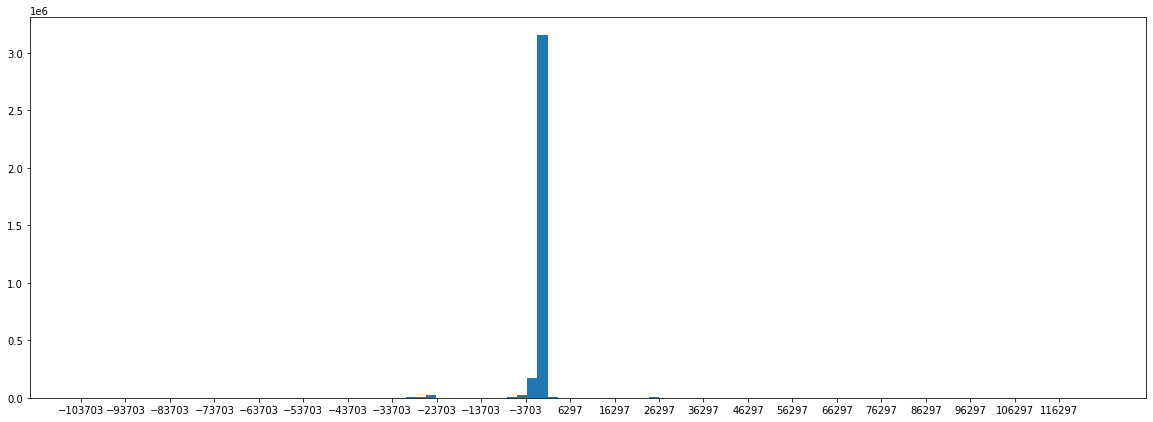

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))
plt.xticks(np.arange(-103703, 124444, step=10000))
n,bins,patch = plt.hist(data.loc[:,'real_cp'], bins=100)

Мы получили распределение продолжительности игры. Из графика видно среднюю продолжительность игры и в каких пределах лежит продолжительность большинства игр.

# Кластеризация методом k средних

In [6]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data)
data['class_labels'] = kmeans.labels_
kmeans.cluster_centers_

In [ ]:
data['class_labels'].value_counts()

9    442230
6    442029
1    441962
2    427505
3    422857
5    421265
7    391714
0    387215
8     19229
4     14086
Name: class_labels, dtype: int64

# Yee-haw

In [9]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics
import matplotlib.pyplot as plt

In [10]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/shogi/db40_2_move.csv', delimiter=',')

In [11]:
clusters = range(2,15) 
distances_sum = [] # Функция расстояния
calinski_mas = []
silgouette_mas_1 = []
silgouette_mas_10 = []
silgouette_mas_20 = []
 
for k in clusters:
    kmeans_model = KMeans(n_clusters = k, random_state=0).fit(data)
    # print('Координатная точка центра кластера:', kmeans_model.cluster_centers_)
         # Вычислить евклидово расстояние каждого объекта от центра различных кластеров, создать таблицу расстояний, размер (15, k)
    distances_point = cdist(data, kmeans_model.cluster_centers_, 'euclidean')
         # Извлеките расстояние от каждого объекта до центра его кластера (расстояние самое короткое, поэтому используйте функцию min) и сложите их.
    distances_cluster = sum(np.min(distances_point,axis=1))
         # Сохранять результаты расстояний диапазона (1, 12) последовательно
    distances_sum.append(distances_cluster)
    ## Индекс Калински-Харабаша - как критерий отношения дисперсии, где более высокий показатель Калински-Харабаса относится к модели с более четко определенными кластерами.
    calinski_mas.append(metrics.calinski_harabasz_score(data, kmeans_model.labels_))
    ## Коэффициент силуэта
    silgouette_mas_1.append(metrics.silhouette_score(data, kmeans_model.labels_, metric='euclidean', sample_size=10000))
    silgouette_mas_10.append(metrics.silhouette_score(data, kmeans_model.labels_, metric='euclidean', sample_size=100000))
    silgouette_mas_20.append(metrics.silhouette_score(data, kmeans_model.labels_, metric='euclidean', sample_size=200000))

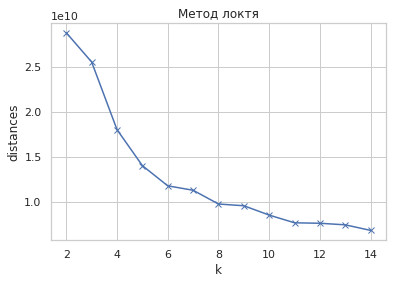

In [12]:
plt.title("Метод локтя") 
plt.plot(clusters, distances_sum, 'bx-')
plt.xlabel('k')
plt.ylabel('distances')
plt.show()

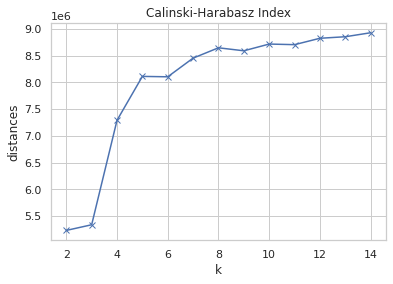

In [13]:
plt.title("Calinski-Harabasz Index")
plt.plot(clusters, calinski_mas, 'bx-')
plt.xlabel('k')
plt.ylabel('distances')
plt.show()

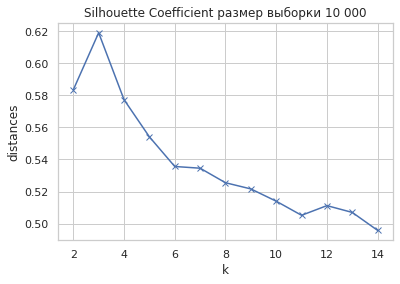

In [14]:
plt.title("Silhouette Coefficient размер выборки 10 000")
plt.plot(clusters, silgouette_mas_1, 'bx-')
plt.xlabel('k')
plt.ylabel('distances')
plt.show()

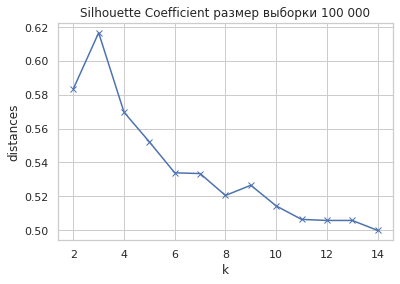

In [15]:
plt.title("Silhouette Coefficient размер выборки 100 000")
plt.plot(clusters, silgouette_mas_10, 'bx-')
plt.xlabel('k')
plt.ylabel('distances')
plt.show()

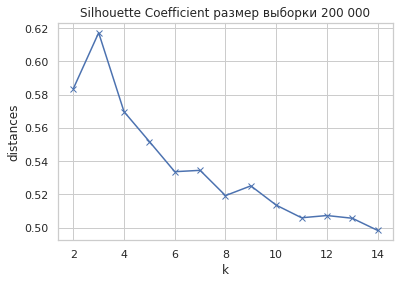

In [16]:
plt.title("Silhouette Coefficient размер выборки 200 000")
plt.plot(clusters, silgouette_mas_20, 'bx-')
plt.xlabel('k')
plt.ylabel('distances')
plt.show()

хмхмхмхмхмхмхм